# Train and Test Model for predicting customer who are likely to purchase in next 7 days
### Here we are using data from kaggle. The data belongs to retail company h&m

### We have following data
### transactions data - this contains the transaction details wth customer and product id along with toal price of sale
### customers data - this contains customer details with membership status, age etc
### items data - this contains item metadata with product group, description etc

### The idea is to use the transactions, customer and item data to predict if a customer is likely to purchase in next 7 days and then recommend top 12 items for the user

## Approach
### We will divide this problem in 2 parts . Part-1 Predict if a customer is likely to purchase in next 7 days. We will make this a classification problem. Part #2 - Using list pf popular items identified we will predict the score for each item for the customer. Higher the score higher the rank of the product for the customer. The caller application can use this data to pick top 12 items as customer;s recommendation

### We will use the transactions data to claculate customer characteristics like Recency, Frequency and Money spent on purchases. We will formulate a RFM score with these data for each of the customer in transaction data
### We will use days spent between last 3 transactions to determine the next transaction date
### So only those customers will be considered who have made atleast 4 purchases
### the time gap for latest transaction of the customer  will be considered as label in our training and testing data. 
### The customer metadata like age, membership status, customer status etc will be added to the training and testing data along with days between transaction
### The label will be classification lable. For next transaction day less equals to 7 days will be considered as 1 while anyting greater than 7 days will be considered as 0
### this makes this problem a classification problem
### We will attempt to use multiple algorithms like XGBoost, RandomForest classification and deep learning based model

In [2]:
import pandas as pd
import sagemaker
from sklearn.cluster import KMeans

In [3]:
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
bucket

'sagemaker-ap-south-1-659144925604'

### Data is stored in S3 bucket and read here

In [4]:
folder='kaggle'
data_key = 'transactions_train.csv'
data_location = 's3://{}/{}/{}'.format(bucket, folder,data_key)
pd.set_option('max_colwidth', 100)  # default is 50
df = pd.read_csv(data_location)
pd.set_option('max_colwidth', 100)  # default is 50
# #df = pd.read_csv("fm_preprocessed.csv")
# df["detail_desc"].fillna("", inplace=True)

# # The list of top customers (customers with the most product reviews).
# df.groupby("customer_id").count()["article_id"].sort_values(ascending=False).head(30)

### Lets see the preview of the data

In [5]:
tx_data=df
tx_data


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e6936f26ea7ecaa68a1,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e593881ae6007d775f0f,833459002,0.006763,1


### Following are the details of the transaction data
- t_dat - Transaction date
- customer_id - Encoded customer unique id
- article_id - Unique product ID
- price - Dollar retail price for the item
- sales_channel_id - Wich channel was used for the purchase

In [6]:
tx_data.shape

(31788324, 5)

In [7]:
tx_data.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [8]:
print("Unique customers  = ",tx_data.customer_id.unique().size)
print("Unique Products = ",tx_data.article_id.unique().size)

Unique customers  =  1362281
Unique Products =  104547


#### Since the transaction date is String, we can convert this feature into a timestamp

In [9]:
tx_data['t_dat'] = pd.to_datetime(tx_data['t_dat'])


#### Since customer id field is encoded string which will be problem in training the model, we will replace customer Id with index value and save the dictionary of encoded customer id and index value for future referece. Then we can drop the encoded value

In [10]:
tx_data.rename(columns = {'customer_id':'customer_id_encoded'}, inplace = True)
tx_user = pd.DataFrame(tx_data['customer_id_encoded'].unique())
tx_user.columns = ['customer_id_encoded']
tx_user['customer_id'] = tx_user.index+1
tx_customer_index_mapping=tx_user[['customer_id','customer_id_encoded']]
tx_customer_index_mapping.to_csv('customer_mapping.csv')
tx_data = pd.merge(tx_data,tx_customer_index_mapping,on='customer_id_encoded',how='left')

### We no longer need the encoded customer ID

In [11]:
tx_data=tx_data.drop("customer_id_encoded",axis=1)

In [12]:
tx_user=tx_user.drop("customer_id_encoded",axis=1)

In [13]:
tx_data.head()

,t_dat,article_id,price,sales_channel_id,customer_id
0,2018-09-20,663713001,0.050831,2,1
1,2018-09-20,541518023,0.030492,2,1
2,2018-09-20,505221004,0.015237,2,2
3,2018-09-20,685687003,0.016932,2,2
4,2018-09-20,685687004,0.016932,2,2


### Read the customer data from customers.csv

In [14]:
customer_key = 'customers.csv'
user_location = 's3://{}/{}/{}'.format(bucket, folder,customer_key)
pd.set_option('max_colwidth', 100)  # default is 50
df_cust = pd.read_csv(user_location)


### replace the encoded customer id with numeric customer id from previous step

In [15]:
tx_mapping=pd.read_csv('./customer_mapping.csv')
df_cust.rename(columns = {'customer_id':'customer_id_encoded'}, inplace = True)
df_cust = pd.merge(df_cust,tx_mapping,on='customer_id_encoded',how='left')
df_cust.head()


,customer_id_encoded,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,Unnamed: 0,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100,568616.0,568617.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057,13987.0,13988.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc,0.0,1.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c222539af5973a23ae6d,877559.0,877560.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd4564743b005a805b1d,221115.0,221116.0


In [16]:
df_cust.columns

Index(['customer_id_encoded', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'Unnamed: 0',
       'customer_id'],
      dtype='object')

### Following are the details of the customers data
- customer_id_encoded - Transaction date
- FN - First Name. Not a useful feature for this column
- Active - If customer is active customer at present
- club_member_status - Status of customer club membership
- fashion_news_frequency - Wich channel was used for the purchase
- age - Age of customer
- postal_code - Area zip code for the customer Tis column has hig cardinality and not very useful


In [17]:
df_cust.Active.value_counts()

1.0    464404
Name: Active, dtype: int64

In [18]:
df_cust.Active.isna().sum()

907576

### There are 907K records where Active value is na. We can recreate a new column called status. whic is a binary feature. Active = 1 Others =0 

In [19]:
df_cust['status'] = df_cust['Active'].fillna(0)

In [20]:
df_cust.status.value_counts()

0.0    907576
1.0    464404
Name: status, dtype: int64

In [21]:
df_cust["fashion_news_frequency"].value_counts()

NONE         877711
Regularly    477416
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

### Some data cleansing is required for Fashion news frequency, For fashion news frequency replace None with NONE

In [22]:
df_cust["fashion_news_frequency"]=df_cust["fashion_news_frequency"].replace("None", "NONE",regex=True)

In [23]:
df_cust.columns

Index(['customer_id_encoded', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'Unnamed: 0',
       'customer_id', 'status'],
      dtype='object')

In [24]:
df_cust.postal_code.nunique()

352899

### Postal code has very high cardinality and is not useful feature. It qualifies neither an Ordinal or Nominal categorical feature. If we have some idea about some popular postal codes from business analysts of company then we may create some categorical attributes with this. As of now it is best to ignore this feature

### Remove unwanted columns like postal code which has very high cardinality, First Name, Active (Since a new Status column was created from this)

In [25]:
col_drop=['postal_code','FN','customer_id_encoded','Unnamed: 0','Active']
df_cust=df_cust.drop(col_drop,axis=1)

In [26]:
df_cust.head()

,club_member_status,fashion_news_frequency,age,customer_id,status
0,ACTIVE,NONE,49.0,568617.0,0.0
1,ACTIVE,NONE,25.0,13988.0,0.0
2,ACTIVE,NONE,24.0,1.0,0.0
3,ACTIVE,NONE,54.0,877560.0,0.0
4,ACTIVE,Regularly,52.0,221116.0,1.0


### Lets do one hot encoding on categorical features - club_member_status, fashion_news_frequency

In [27]:
df_cust=pd.get_dummies(df_cust)

In [28]:
df_cust.columns

Index(['age', 'customer_id', 'status', 'club_member_status_ACTIVE',
       'club_member_status_LEFT CLUB', 'club_member_status_PRE-CREATE',
       'fashion_news_frequency_Monthly', 'fashion_news_frequency_NONE',
       'fashion_news_frequency_Regularly'],
      dtype='object')

### checking for any undefined values

In [29]:
df_cust.isna().sum()

age                                 15861
customer_id                          9699
status                                  0
club_member_status_ACTIVE               0
club_member_status_LEFT CLUB            0
club_member_status_PRE-CREATE           0
fashion_news_frequency_Monthly          0
fashion_news_frequency_NONE             0
fashion_news_frequency_Regularly        0
dtype: int64

### Lets do some further cleanups
- Lets replace age with the mean age of all the  customers where age is undefined 
- We see some customer ids are undefined. These are those customers which were there in customers.csv but those customer ids were not present in transaction data. Which means that these customers have never done any transaction for the said time period and not very useful for us. So we can safgely remove these customers from our customers data

In [30]:
df_cust['age'].fillna(df_cust['age'].mean(), inplace=True)

In [31]:
df_cust=df_cust.dropna()
df_cust.isna().sum()

age                                 0
customer_id                         0
status                              0
club_member_status_ACTIVE           0
club_member_status_LEFT CLUB        0
club_member_status_PRE-CREATE       0
fashion_news_frequency_Monthly      0
fashion_news_frequency_NONE         0
fashion_news_frequency_Regularly    0
dtype: int64

In [32]:
df_cust.to_csv("user_mapping.csv")

## Lets collect all customer Ids grouped in one data frame and calculate Recency, Frequency And Monetory Score for each customer


# Recency
### Recency is defined as how soon a customer purchased. Lower the recency number the better are chances of customer purchasing in next few days. So we will reward the lower recency number with better score

#### We will follow following steps in calculating the recency score
- Group customer ID with last purchase date in te timeperiod
- Calculate the max transactions date from the whole transaction data
- For each customer calculate recency days by subtracting the customer;s max transaction date with the dataset's max transaction date
- Pass all the recency days to a KMeans and calculate the optimum number of clusters
- Each recency day is attributed to a cluster ID (0,1,2,3 ..)
- The cluster ID can be manipulated as a recency score (1,2,3..)
- Higher the recency number lower the recency score

In [33]:
tx_max_purchase = tx_data.groupby('customer_id').t_dat.max().reset_index()
tx_max_purchase.columns = ['customer_id','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['customer_id','Recency']], on='customer_id')

In [34]:
tx_user

,customer_id,Recency
0,1,7
1,2,132
2,3,174
3,4,8
4,5,160
...,...,...
1362276,1362277,0
1362277,1362278,0
1362278,1362279,0
1362279,1362280,0


In [35]:
tx_user.Recency.describe()

count    1.362281e+06
mean     2.351484e+02
std      2.211188e+02
min      0.000000e+00
25%      4.800000e+01
50%      1.510000e+02
75%      3.980000e+02
max      7.330000e+02
Name: Recency, dtype: float64

### We have recency number.Now we can create clusters from these recency numbers and try to assign a score against each cluster. Remember lower recency number will be rewarded with a better score

#### Lets run KMeans on Recency numbers and cluster them in unique clusters

In [36]:
from sklearn.cluster import KMeans


In [37]:
!pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


#### Identify optimum number of clusters between 1-10 by running Kmeans with cluster numbers from 1-10

In [38]:

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    #tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 


#### Lets visualise the cluster number against the loss

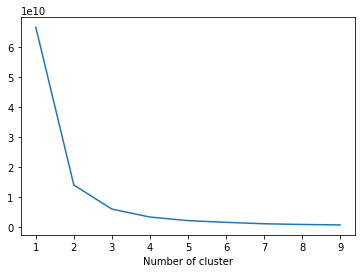

In [39]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### number of clusters can be choosen as much 4

In [40]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [41]:
tx_user.RecencyCluster.unique()

array([0, 2, 3, 1], dtype=int32)

#### Defining a utility function to order the cluster number against the score. 
- cluster_field_name - Column against which cluster Id was assigned
- Target_filed_name - Column name of the new score column which will be added to the dataset
- df - pandas dataset on which we are working
- ascending - boolean field. This defines if score is directly proportional to the cluster id value. e.g Lower recency cluster number means High score which means ascending should be passed as false, similarly higher frequency should result in higher score so here ascending should be passed as true

In [42]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [43]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [44]:
tx_user.groupby('RecencyCluster')['Recency'].describe()
tx_user['RecencyCluster'].unique()

array([3, 2, 0, 1])

# Frequency
#### The Frequency is defined as how often the customer purchases. Higher the number the higher is the score for the customer

#### We will follow following steps in calculating the Frequency score
- Group customer ID with total purchases. Lets call that column as Frequency
- Pass all the Frequency days to a KMeans and calculate the optimum number of clusters
- Each frequency day is attributed to a cluster ID (0,1,2,3 ..)
- The cluster ID can be manipulated as a frequency score (1,2,3..)
- Higher the frequency number higher the frequency score

In [45]:
tx_frequency = tx_data.groupby('customer_id').t_dat.count().reset_index()
tx_frequency.columns = ['customer_id','Frequency']
tx_frequency.head()

,customer_id,Frequency
0,1,18
1,2,120
2,3,27
3,4,61
4,5,57


In [46]:
tx_user = pd.merge(tx_user, tx_frequency, on='customer_id')

In [47]:
tx_user.Frequency.describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: Frequency, dtype: float64

#### Lets run K means on the frequency number and try to find the optimum number of clusters

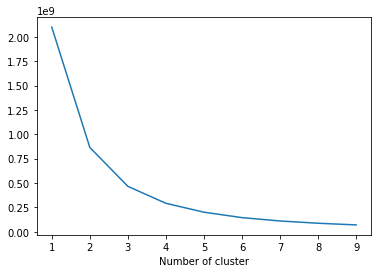

In [48]:
sse_freq={}
tx_freq= tx_user[['Frequency']]
for k in range(1, 10):
    kmeans_freq = KMeans(n_clusters=k, max_iter=1000).fit(tx_freq)
    #tx_freq["clusters"] = kmeans_freq.labels_
    sse_freq[k] = kmeans_freq.inertia_ 
plt.figure()
plt.plot(list(sse_freq.keys()), list(sse_freq.values()))
plt.xlabel("Number of cluster")
plt.show()


In [49]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [50]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,249731.0,48.900801,15.833739,29.0,35.0,45.0,60.0,87.0
1,63578.0,126.686196,32.585245,88.0,100.0,118.0,146.0,216.0
2,9126.0,306.566075,107.850046,217.0,239.0,272.0,334.0,1895.0
3,1039846.0,8.389801,7.267233,1.0,3.0,6.0,13.0,28.0


In [51]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [52]:
tx_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster
0,1,7,3,18,0
1,25,16,3,17,0
2,30,54,3,16,0
3,34,7,3,16,0
4,37,93,3,24,0


# Monetary Value
### Total money spend by customer will contribute to monetary score. More the total spend more is the revenue score . Lets calculate the Monetary value of each customer

#### We will follow following steps in calculating the Monetary score
- Group customer ID with total money spent on purchases.
- Pass all the Price  to a KMeans and calculate the optimum number of clusters
- Each Price number is attributed to a cluster ID (0,1,2,3 ..)
- The cluster ID can be manipulated as a Monetary score (1,2,3..)
- Higher the Monetary value higher  the Monetary score

In [53]:
tx_revenue = tx_data.groupby('customer_id').price.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='customer_id')
tx_user.price.describe()

count    1.362281e+06
mean     6.493858e-01
std      1.197582e+00
min      7.627119e-04
25%      8.806780e-02
50%      2.455932e-01
75%      7.011864e-01
max      5.767641e+01
Name: price, dtype: float64

In [54]:
tx_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,price
0,1,7,3,18,0,0.704780
1,25,16,3,17,0,0.872593
2,30,54,3,16,0,0.456186
3,34,7,3,16,0,0.410322
4,37,93,3,24,0,0.729339


#### Again running K-means on the total price number and create optimum number of cluster. Then we can align each price total to a score

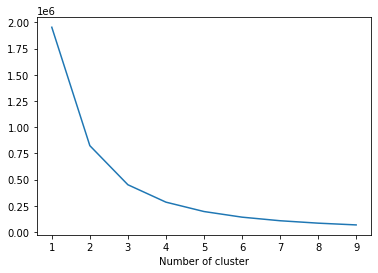

In [55]:
sse={}
tx_revenue = tx_user[['price']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    #tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [56]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['price']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['price']])

In [57]:
tx_user = order_cluster('RevenueCluster', 'price',tx_user,True)

In [58]:
tx_user.groupby('RevenueCluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1091711.0,0.247928,0.224974,0.000763,0.068610,0.164797,0.368407,0.899017
1,214953.0,1.552148,0.525924,0.899034,1.111169,1.413525,1.897186,2.897576
2,48707.0,4.250057,1.139336,2.897593,3.321907,3.924881,4.932373,7.423254
3,6910.0,10.612791,3.940668,7.423966,8.206381,9.342881,11.574021,57.676407


### After calculating the RFM score for each customer , now we will generate some more features
#### Here were are cretaing following feature - Given a transaction record for a customer - What were days spent for this transaction and what were the days spent for past other 2 transaction
### Following features will be created
- DayDiff - For the given transaction date how many days customer took to make this transaction with the store
- DayDiff2 - On the same context how many days customer took to make the previous to this transaction 
- DayDiff3 - One the same context how many days customer took to make the previous to previous to this transaction
#### We are going through previous transaction done by customer for a given transaction record. 

#### For each transaction order keep the customer id and transaction date and sort for each customer id and transaction date. Drop the duplicates

In [59]:
tx_day_order = tx_data[['customer_id','t_dat']]
tx_day_order['InvoiceDay'] = tx_data['t_dat'].dt.date
tx_day_order = tx_day_order.sort_values(['customer_id','t_dat'])
tx_day_order = tx_day_order.drop_duplicates(subset=['customer_id','InvoiceDay'],keep='first')

<ipython-input-59-1cb900ec3fdc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_day_order['InvoiceDay'] = tx_data['t_dat'].dt.date


#### Now for each customer record Identify Previous 3 transaction dates.

In [60]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(3)

### We are interested in the difference between days
### DayDiff is the differnece of days after which customer made the current purchase
#### DayDiff2 is difference of days from current to previous to last and Similarly DayDiff3 is diff of current with previous to previous to last

In [61]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [62]:
tx_day_diff= tx_day_order[['customer_id','DayDiff2', 'DayDiff3','DayDiff']].reset_index()

If the customer has not made atleast 4 transactions then we would have na on DayDiff3 or other DayDiff columns. We can simply drop these records

In [63]:
tx_day_diff.isna().sum()

index                0
customer_id          0
DayDiff2       2276589
DayDiff3       3007781
DayDiff        1362281
dtype: int64

In [64]:
tx_day_diff.shape

(9080179, 5)

In [65]:
tx_day_diff.dropna().shape

(6072398, 5)

In [66]:
tx_day_diff=tx_day_diff.dropna()


In [67]:
tx_day_diff.isna().sum()

index          0
customer_id    0
DayDiff2       0
DayDiff3       0
DayDiff        0
dtype: int64

In [68]:
tx_day_diff.columns

Index(['index', 'customer_id', 'DayDiff2', 'DayDiff3', 'DayDiff'], dtype='object')

### Lets merge this DayDiff columns with the user data

In [69]:
tx_user = pd.merge(tx_user, tx_day_diff[['customer_id','DayDiff','DayDiff2','DayDiff3']], on='customer_id')


In [70]:
tx_user.columns


Index(['customer_id', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'price', 'RevenueCluster', 'DayDiff', 'DayDiff2',
       'DayDiff3'],
      dtype='object')

In [71]:
tx_user.isna().sum()

customer_id         0
Recency             0
RecencyCluster      0
Frequency           0
FrequencyCluster    0
price               0
RevenueCluster      0
DayDiff             0
DayDiff2            0
DayDiff3            0
dtype: int64

### lets drop the correlated columns. since we calculated the score against the Recency, Frequency and price already we dont need this columns as they are now corelated

In [72]:
columnsToDrop=['Recency','Frequency','price']

In [73]:
tx_user=tx_user.drop(columnsToDrop,axis=1)

#### previously we had collected the user metadata. We can merge this data with tx_user. Lets name the new data set as cust_attributes.

In [74]:
cust_attributes = pd.merge(tx_user, df_cust, on='customer_id')
#cust_attributes=cust_attributes.drop('customer_id',axis=1)

In [75]:
cust_attributes

,customer_id,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_Regularly
0,1,3,0,0,339.0,497.0,501.0,24.0,0.0,1,0,0,0,1,0
1,1,3,0,0,58.0,397.0,555.0,24.0,0.0,1,0,0,0,1,0
2,1,3,0,0,17.0,75.0,414.0,24.0,0.0,1,0,0,0,1,0
3,1,3,0,0,150.0,167.0,225.0,24.0,0.0,1,0,0,0,1,0
4,25,3,0,0,87.0,122.0,216.0,23.0,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072393,559818,1,3,3,1.0,5.0,10.0,64.0,1.0,1,0,0,0,0,1
6072394,559818,1,3,3,3.0,4.0,8.0,64.0,1.0,1,0,0,0,0,1
6072395,559818,1,3,3,3.0,6.0,7.0,64.0,1.0,1,0,0,0,0,1
6072396,559818,1,3,3,1.0,4.0,7.0,64.0,1.0,1,0,0,0,0,1


In [76]:
cust_attributes.isna().sum()

customer_id                         0
RecencyCluster                      0
FrequencyCluster                    0
RevenueCluster                      0
DayDiff                             0
DayDiff2                            0
DayDiff3                            0
age                                 0
status                              0
club_member_status_ACTIVE           0
club_member_status_LEFT CLUB        0
club_member_status_PRE-CREATE       0
fashion_news_frequency_Monthly      0
fashion_news_frequency_NONE         0
fashion_news_frequency_Regularly    0
dtype: int64

In [77]:
cust_attributes.head()

,customer_id,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_Regularly
0,1,3,0,0,339.0,497.0,501.0,24.0,0.0,1,0,0,0,1,0
1,1,3,0,0,58.0,397.0,555.0,24.0,0.0,1,0,0,0,1,0
2,1,3,0,0,17.0,75.0,414.0,24.0,0.0,1,0,0,0,1,0
3,1,3,0,0,150.0,167.0,225.0,24.0,0.0,1,0,0,0,1,0
4,25,3,0,0,87.0,122.0,216.0,23.0,1.0,1,0,0,0,0,1


Lets describe the columns
- customer_id - Unique id for customer
- Recencycluster - Recency score
- FrequencyCluster - Frequency Score
- RevenueCluster - Monetary score
- DayDiff - Diff in days customer took to make current transaction
- DayDiff2 - Diff in days customer took to make previous tx
- DayDiff3 - Diff in days customer took to make previous to previous tx
- age - age of customer
- status - Whether customer is active member r not
- club)member_status_* - club membership status categorical value
- fashion_news_frequency_* - frequency of fashion news subscription - categorical

#### Here DayDiff becomes our target column. We can interpret this in a way that Given some customer attributes like RFM scores, age, statuses, membership status, difference of days of last 2 transactions, what will be the next number of days that customer is likely to purchase (In our case that lebel is DayDiff)

#### But instead of identifying as Regression problem we can also consider this as a classification problem and identify label , if DayDiff is <=7 then label is 1 otherwise 0. So the model will try to learn and predict this label

#### lets call the label as CustomerBuyNext7Days

In [78]:
cust_attributes['CustomerBuyNext7days'] = 1
cust_attributes.loc[cust_attributes.DayDiff>7,'CustomerBuyNext7days'] = 0


#### Lets see the distribution of the labels

In [79]:
cust_attributes.CustomerBuyNext7days.value_counts()/len(cust_attributes)

0    0.715902
1    0.284098
Name: CustomerBuyNext7days, dtype: float64

#### We dont need the DayDiff column anymore

In [80]:
cust_attributes=cust_attributes.drop('DayDiff',axis=1)

#### lets see correlation of multiple attributes of the data

<AxesSubplot:>

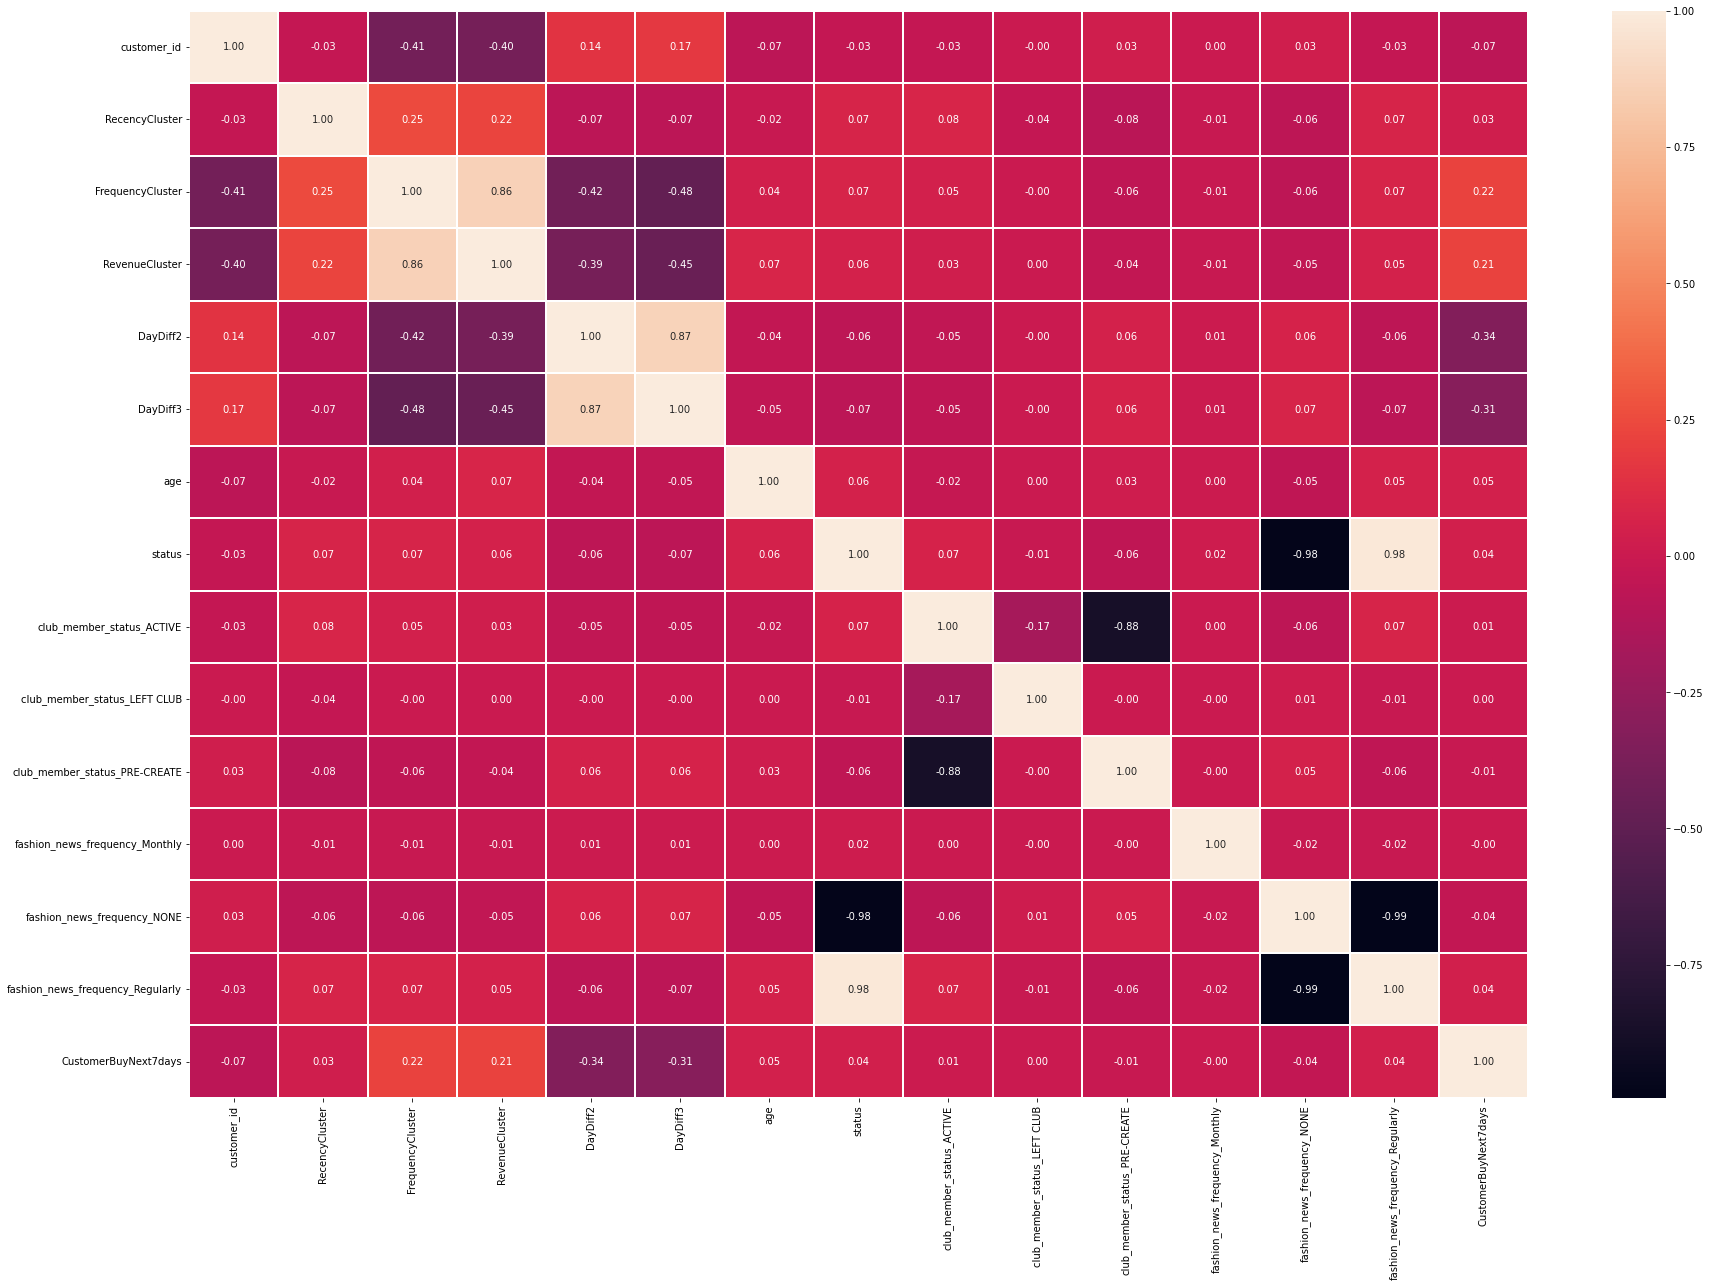

In [81]:
import seaborn as sns
corr = cust_attributes[cust_attributes.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

#### We can drop fashion_news_frequencyz-none as it is redundant ansd highly corelated, as well as club_memeber_status_pre_create

In [82]:
cust_attributes=cust_attributes.drop(['fashion_news_frequency_NONE','club_member_status_PRE-CREATE'],axis=1)

#### Split dataset using sklearn train_test_split

In [83]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [84]:
X, y = cust_attributes.drop('CustomerBuyNext7days',axis=1), cust_attributes.CustomerBuyNext7days

In [85]:
X

,customer_id,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,fashion_news_frequency_Monthly,fashion_news_frequency_Regularly
0,1,3,0,0,497.0,501.0,24.0,0.0,1,0,0,0
1,1,3,0,0,397.0,555.0,24.0,0.0,1,0,0,0
2,1,3,0,0,75.0,414.0,24.0,0.0,1,0,0,0
3,1,3,0,0,167.0,225.0,24.0,0.0,1,0,0,0
4,25,3,0,0,122.0,216.0,23.0,1.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6072393,559818,1,3,3,5.0,10.0,64.0,1.0,1,0,0,1
6072394,559818,1,3,3,4.0,8.0,64.0,1.0,1,0,0,1
6072395,559818,1,3,3,6.0,7.0,64.0,1.0,1,0,0,1
6072396,559818,1,3,3,4.0,7.0,64.0,1.0,1,0,0,1


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=44)

In [87]:
y

0          0
1          0
2          0
3          0
4          0
          ..
6072393    1
6072394    1
6072395    1
6072396    1
6072397    0
Name: CustomerBuyNext7days, Length: 6072398, dtype: int64

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=44)

Its wise to keep a validation data set as well 

In [89]:
X_train, X_train_cust_id = X_train.drop('customer_id',axis=1), X_train.customer_id
X_val, X_val_cust_id = X_val.drop('customer_id',axis=1), X_val.customer_id
X_test, X_test_cust_id = X_test.drop('customer_id',axis=1), X_test.customer_id

In [90]:
X_train_cust_id.to_csv("X_train_cust_id.csv")
X_val_cust_id.to_csv("X_val_cust_id.csv")
X_test_cust_id.to_csv("X_test_cust_id.csv")

In [91]:
X_train.shape

(4645384, 11)

In [92]:
X_val.shape

(516154, 11)

In [93]:
X_test.shape

(910860, 11)

#### Apply Normalization on  Age, DayDiff2 and DayDiff3

In [94]:
from sklearn.preprocessing import MinMaxScaler 
minmaxscaler_age = MinMaxScaler() 
minmaxscaler_age.fit(X_train[['age']]) 
X_train['age'] = minmaxscaler_age.transform(X_train[['age']])
X_val['age'] = minmaxscaler_age.transform(X_val[['age']])
X_test['age'] = minmaxscaler_age.transform(X_test[['age']])
minmaxscaler_daydiff2 = MinMaxScaler() 
minmaxscaler_daydiff2.fit(X_train[['DayDiff2']]) 
X_train['DayDiff2'] = minmaxscaler_daydiff2.transform(X_train[['DayDiff2']])
X_val['DayDiff2'] = minmaxscaler_daydiff2.transform(X_val[['DayDiff2']])
X_test['DayDiff2'] = minmaxscaler_daydiff2.transform(X_test[['DayDiff2']])
minmaxscaler_daydiff3 = MinMaxScaler() 
minmaxscaler_daydiff3.fit(X_train[['DayDiff3']]) 
X_train['DayDiff3'] = minmaxscaler_daydiff3.transform(X_train[['DayDiff3']])
X_val['DayDiff3'] = minmaxscaler_daydiff3.transform(X_val[['DayDiff3']])
X_test['DayDiff3'] = minmaxscaler_daydiff3.transform(X_test[['DayDiff3']])


In [95]:
X_train.age.describe()

count    4.645384e+06
mean     2.496144e-01
std      1.649588e-01
min      0.000000e+00
25%      1.084337e-01
50%      1.927711e-01
75%      3.975904e-01
max      1.000000e+00
Name: age, dtype: float64

In [96]:
X_train.DayDiff2.describe()

count    4.645384e+06
mean     1.035478e-01
std      1.121158e-01
min      0.000000e+00
25%      2.912621e-02
50%      6.657420e-02
75%      1.373093e-01
max      1.000000e+00
Name: DayDiff2, dtype: float64

Check the distribution of dayDiff from training and test dataset

(array([3325022.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1320362.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

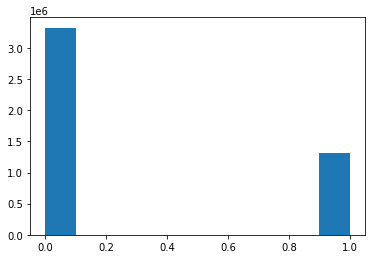

In [97]:
plt.hist(y_train)

In [98]:
!pip install xgboost

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#### Lets see which classification model gives good precision. I am choosing precision as this may be important metric to calcuate. Precision says that if my model is saying that this customer is likely to purchase in next 7 days then probability of that happening for that prediction is on higher side. So we are trying to minimize False Positives. Since these customers willbe target of marletting campaigns and eligible for offers which means there is investment being done by company on these customers so it is important that precision of prediction is good. So lets try to gauge our models
### We are checking for LogisticRegression, RandomForestClassifier and XGBosst classifer

In [100]:
models = []
models.append(("LR",LogisticRegression()))
#models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
#models.append(("SVC",SVC()))
#models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
#models.append(("KNN",KNeighborsClassifier()))

In [101]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "precision")
    print(name, cv_result)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR [0.79655316 0.79940727]
RF [0.66629882 0.66736483]
XGB [0.83112282 0.84249518]


### XGBoost was the winner so we wil try to train the XGBoost classifier with default values and see the results

In [102]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [103]:
y_pred = xgb_model.predict(X_test)

In [104]:
from sklearn.metrics import classification_report,confusion_matrix


In [105]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89    652582
           1       0.84      0.47      0.60    258278

    accuracy                           0.82    910860
   macro avg       0.83      0.71      0.74    910860
weighted avg       0.82      0.82      0.80    910860



### Lets do some Hyperparameters tuning for our XgBosst model. We will try to iterate in max_depth and min_child_weight hyperparameter and select best options and then train the model with these hyperparameters

In [106]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,15),
 'min_child_weight':range(1,6)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='precision',n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 2}, 0.8348849150683391)

In [107]:
xgb_model = xgb.XGBClassifier(max_depth=3,min_child_weight=3).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [108]:
y_pred = xgb_model.predict(X_test)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89    652582
           1       0.84      0.47      0.60    258278

    accuracy                           0.82    910860
   macro avg       0.83      0.71      0.74    910860
weighted avg       0.82      0.82      0.80    910860



## Lets also try to train a Neural Network model and see how it performs. For this we can use tensor flow with Keras

In [110]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [111]:
## CODE HERE
model = Sequential()

# Remember to compile()
model.add(Dense(11,activation='relu'))
#model.add(Dropout(0.2))  // since model shows no signs of overfit I decided to not use the droput

model.add(Dense(5,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(5,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')


In [112]:
model.fit(x=X_train,y=y_train,epochs=25,batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/25
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-04-17 04:21:38.215 tensorflow-2-6-cpu-p-ml-m5-4xlarge-0ff1e2c27204253a5437e9d6f1d4:185 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-17 04:21:38.267 tensorflow-2-6-cpu-p-ml-m5-4xlarge-0ff1e2c27204253a5437e9d6f1d4:185 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
18147/18147 [==============================] - 45s 2ms/step - loss: 0.4341 - val_loss: 0.4159
Epoch 2/25
18147/18147 [==============================] - 44s 2ms/step - loss: 0.4165 - val_loss: 0.4231
Epoch 3/25
18147/18147 [==============================] - 45s 2ms/step - loss: 0.4157 - val_loss: 

#### Lets visualize the training and validation loss.

<AxesSubplot:>

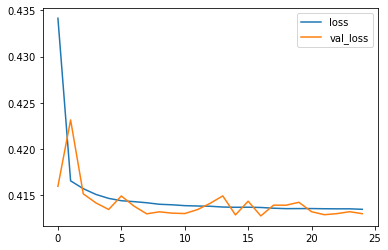

In [113]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

#### We can see that model shows no sign of Overfitting and it performed well on training loss as well. We can later further tune this with multple Hyper paremetrs experimentation

#### Lets predict the result with hold out test set

In [114]:
predictions = model.predict(X_test)

#### convert predictions to binary with threshold as 0.5

In [115]:
pred_com=predictions.copy()


In [116]:
def mapbinary(i):
    if i>=0.5:
        return 1
    return 0
    

In [117]:
import numpy as np
applyall = np.vectorize(mapbinary)

In [118]:
pred_mod=applyall(pred_com)

In [119]:
print(classification_report(y_test,pred_mod))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89    652582
           1       0.86      0.44      0.58    258278

    accuracy                           0.82    910860
   macro avg       0.84      0.71      0.74    910860
weighted avg       0.83      0.82      0.80    910860



In [129]:
cust_id_test=pd.read_csv("X_test_cust_id.csv")
# lets club customr id with the result and find which customer id recommendations to be done
cust_in_rec=cust_id_test.join(pd.DataFrame(data=pred_mod,columns =["BuyNext7Days"])).reset_index()
print(cust_in_rec.columns)
#cust_in_rec.rename(columns = {'0':'BuyNext7Days'}, inplace = True)

cust_in_rec=cust_in_rec.drop("Unnamed: 0",axis=1).query("BuyNext7Days==1")
cust_in_rec

Index(['index', 'Unnamed: 0', 'customer_id', 'BuyNext7Days'], dtype='object')


,index,customer_id,BuyNext7Days
4,4,115966,1
23,23,287273,1
24,24,70661,1
30,30,16953,1
31,31,200489,1
...,...,...,...
910808,910808,127689,1
910809,910809,106277,1
910817,910817,556917,1
910841,910841,45273,1


#### Looks like we also get good results from neural network model

In [132]:
cust_in_rec.to_csv("input_customers_rec.csv")

### What we did
- We used the transaction data to calculate the RFM score for each customer
- We created new features from the days customer took to make current and Previous 2 transaction or purchases
- We Used the customer data to get customer attributes
- The days customer took to make the current transaction becomes our label for the dataset
- We used this data to split in training, validation and test dataset
- We calculated the precision of the predictions made by different modes
- We then used one of the model to calulate the prediction whether customer will purchase in next 7 days
- We will save these customer IDs for future use

### For next step move to this __[notebook](https://github.com/vivekghi/customer-purchase-prediction-and-recommendation/blob/main/2-Customer-Product-sparse-data-prep-with-attributes.ipynb)__